In [1]:
import pandas as pd
import numpy as np
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Read and filter data

In [2]:
file_name = "./german.data"

#read file
all_data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)

all_data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

# translate from codes to descriptive things
all_data.replace({"checking_acct": {'A11' : 'lt_0',
 'A12' : '0_to_200',
 'A13' : 'geq_200',
 'A14' : 'no acct'}}, inplace=True)

all_data.replace({"credit_hist": {'A30' : 'no_cred_all_paid',
 'A31' : 'all_credit_bank_paid',
 'A32' : 'existing_credits_paid',
 'A33' : 'delay_in_past',
 'A34' : 'critical_accts_other_bank_credits'}}, inplace=True)

all_data.replace({"purpose": {
 'A40' : 'car_new',
 'A41' : 'car_used',
 'A42' : 'furniture_equipment',
 'A43' : 'radio_tv',
 'A44' : 'home_appliances',
 'A45' : 'repairs',
 'A46' : 'education',
 'A47' : 'vacation',
 'A48' : 'retraining',
 'A49' : 'business',
 'A410' : 'other'}}, inplace=True)

all_data.replace({"savings": {
 'A61' : 'lt_100',
 'A62' : 'lt_500',
 'A63' : '100_to_500',
 'A64' : '500_to_1000',
 'A65' : 'unknown_or_no_account'}}, inplace=True)

all_data.replace({"employ_years": {
 'A71' : 'unemployed',
 'A72' : 'lt_1',
 'A73' : '1_to_4',
 'A74' : '4_to_7',
 'A75' : 'geq_7'}}, inplace=True)

all_data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

all_data.replace({"other_debtors": {
 'A101' : 'none',
 'A102' : 'co_applicant',
 'A103' : 'guarantor'}}, inplace=True)

all_data.replace({"property": {
 'A121' : 'real_estate',
 'A122' : 'building_soc_saving_life_insurance',
 'A123' : 'car_other',
 'A124' : 'unknown_none'}}, inplace=True)

all_data.replace({"other_installments": {
 'A141' : 'bank',
 'A142' : 'stores',
 'A143' : 'none'}}, inplace=True)

all_data.replace({"housing": {
 'A151' : 'rent',
 'A152' : 'own',
 'A153' : 'free'}}, inplace=True)

all_data.replace({"job": {
 'A171' : 'unemploy_unskilled_non_res',
 'A172' : 'unskill_resident',
 'A173' : 'skilled_official',
 'A174' : 'management_self_highQualified_officer'}}, inplace=True)

all_data.replace({"telephone": {
 'A191' : 'none',
 'A192' : 'yes'}}, inplace=True)

all_data.replace({"foreign": {
 'A201' : 'yes',
 'A202' : 'no'}}, inplace=True)

all_data.replace({"ground_truth": {
 1 : 'accepted',
 2 : 'dennied'}}, inplace=True)


all_data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,...,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,lt_0,6,critical_accts_other_bank_credits,radio_tv,1169,unknown_or_no_account,geq_7,4,male_single,none,...,real_estate,67,none,own,2,skilled_official,1,yes,yes,accepted
1,0_to_200,48,existing_credits_paid,radio_tv,5951,lt_100,1_to_4,2,female_div_sep_married,none,...,real_estate,22,none,own,1,skilled_official,1,none,yes,dennied
2,no acct,12,critical_accts_other_bank_credits,education,2096,lt_100,4_to_7,2,male_single,none,...,real_estate,49,none,own,1,unskill_resident,2,none,yes,accepted
3,lt_0,42,existing_credits_paid,furniture_equipment,7882,lt_100,4_to_7,2,male_single,guarantor,...,building_soc_saving_life_insurance,45,none,free,1,skilled_official,2,none,yes,accepted
4,lt_0,24,delay_in_past,car_new,4870,lt_100,1_to_4,3,male_single,none,...,unknown_none,53,none,free,2,skilled_official,2,none,yes,dennied


### clean and create dummies for training

In [3]:
learning_data = all_data.copy(deep=True)
features_to_transform = ['checking_acct', 'credit_hist', 'purpose', 'savings',
                         'employ_years', 'other_debtors', 'property',
                         'other_installments', 'housing', 'job', 'telephone', 'foreign']

temp = pd.DataFrame()
temp['sex'] = learning_data['married_and_sex'].map(lambda x: x.split("_")[0])
dummies = pd.get_dummies(temp["sex"], prefix="sex")
learning_data = pd.concat([learning_data, dummies], axis=1)

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis=1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace(' ', '_')
learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['ground_truth_label'] = np.where(learning_data['ground_truth'] == 'accepted', 'accepted', 'dennied')
dummies = pd.get_dummies(learning_data['ground_truth_label'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
features_to_transform.append("ground_truth")
learning_data.drop(features_to_transform, axis=1, inplace=True)
learning_data.drop("married_and_sex", axis=1, inplace=True)
learning_data.head()

,duration_month,credit_amount,install_as_percent_of_disp_income,resident_since,age,existing_credits,num_liable,sex_female,sex_male,checking_acct_0_to_200,...,job_skilled_official,job_unemploy_unskilled_non_res,job_unskill_resident,telephone_none,telephone_yes,foreign_no,foreign_yes,ground_truth_label,accepted,dennied
0,6,1169,4,4,67,2,1,0,1,0,...,1,0,0,0,1,0,1,accepted,1,0
1,48,5951,2,2,22,1,1,1,0,1,...,1,0,0,1,0,0,1,dennied,0,1
2,12,2096,2,3,49,1,2,0,1,0,...,0,0,1,1,0,0,1,accepted,1,0
3,42,7882,2,4,45,1,2,0,1,0,...,1,0,0,1,0,0,1,accepted,1,0
4,24,4870,3,4,53,2,2,0,1,0,...,1,0,0,1,0,0,1,dennied,0,1


In [4]:
X_Labels = ['duration_month', 'credit_amount', 'install_as_percent_of_disp_income', 'resident_since', 'age', 'existing_credits', 'num_liable', 'checking_acct_0_to_200', 'checking_acct_geq_200', 'checking_acct_lt_0', 'credit_hist_all_credit_bank_paid', 'credit_hist_critical_accts_other_bank_credits', 'credit_hist_delay_in_past', 'credit_hist_existing_credits_paid', 'credit_hist_no_cred_all_paid', 'purpose_business', 'purpose_car_new', 'purpose_car_used', 'purpose_education', 'purpose_furniture_equipment', 'purpose_other', 'purpose_radio_tv', 'purpose_repairs', 'savings_100_to_500', 'savings_500_to_1000', 'savings_lt_100', 'savings_lt_500', 'savings_unknown_or_no_account', 'employ_years_1_to_4', 'employ_years_4_to_7', 'employ_years_geq_7', 'employ_years_lt_1', 'employ_years_unemployed', 'sex_male', 'sex_female', 'other_debtors_co_applicant', 'other_debtors_guarantor', 'other_debtors_none', 'property_building_soc_saving_life_insurance', 'property_car_other', 'property_real_estate', 'property_unknown_none', 'other_installments_bank', 'other_installments_none', 'other_installments_stores', 'housing_A153', 'housing_own', 'housing_rent', 'job_management_self_highQualified_officer', 'job_skilled_official', 'job_unskill_resident', 'foreign_yes']
Y_Labels = ['accepted']

X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(str(column_a) + " " + str(column_b))
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.0002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.35
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params, xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)

[0]	test-auc:0.62928
[1000]	test-auc:0.79877
[2000]	test-auc:0.80226
[3000]	test-auc:0.80346
[4000]	test-auc:0.80478
[5000]	test-auc:0.80514
[6000]	test-auc:0.80863
[7000]	test-auc:0.81080
[8000]	test-auc:0.81296
[9000]	test-auc:0.81368
[9999]	test-auc:0.81584


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show() 

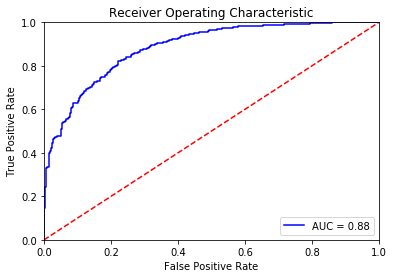

Optimal Threshold obtained using difference of TPR and FPR 0.636692


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['accepted'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

progress: 0.0(duration_month)
progress: 0.019230769230769232(credit_amount)
progress: 0.038461538461538464(install_as_percent_of_disp_income)
progress: 0.057692307692307696(resident_since)
progress: 0.07692307692307693(age)
progress: 0.09615384615384616(existing_credits)
progress: 0.11538461538461539(num_liable)
progress: 0.1346153846153846(checking_acct_0_to_200)
progress: 0.15384615384615385(checking_acct_geq_200)
progress: 0.17307692307692307(checking_acct_lt_0)
progress: 0.19230769230769232(credit_hist_all_credit_bank_paid)
progress: 0.21153846153846154(credit_hist_critical_accts_other_bank_credits)
progress: 0.23076923076923078(credit_hist_delay_in_past)
progress: 0.25(credit_hist_existing_credits_paid)
progress: 0.2692307692307692(credit_hist_no_cred_all_paid)
progress: 0.28846153846153844(purpose_business)
progress: 0.3076923076923077(purpose_car_new)
progress: 0.3269230769230769(purpose_car_used)
progress: 0.34615384615384615(purpose_education)
progress: 0.36538461538461536(pur

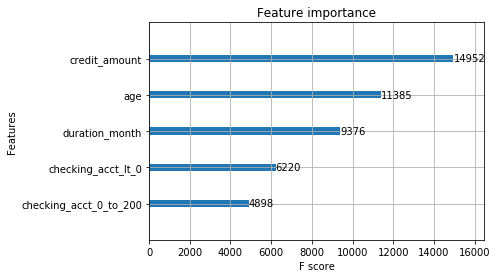

,duration_month_loco,credit_amount_loco,install_as_percent_of_disp_income_loco,resident_since_loco,age_loco,existing_credits_loco,num_liable_loco,checking_acct_0_to_200_loco,checking_acct_geq_200_loco,checking_acct_lt_0_loco,...,housing_own_loco,housing_rent_loco,job_management_self_highQualified_officer_loco,job_skilled_official_loco,job_unskill_resident_loco,foreign_yes_loco,sex_male,age,foreign_yes,foreign_no
0,-0.044678,-0.038873,0.008092,-0.002872,-0.038117,-0.002177,-0.000324,-0.003490,-0.003162,0.062227,...,-0.008277,-0.001214,-0.001201,0.006162,0.000540,0.001336,1,67,1,0
1,0.139777,0.007282,-0.011183,0.010868,0.029109,-0.004203,0.001641,0.095036,-0.001509,-0.032041,...,-0.008016,-0.001402,-0.006903,0.002374,0.001057,0.000126,0,22,1,0
2,-0.018444,-0.042922,-0.003447,-0.004503,-0.043321,-0.000210,0.002316,-0.013650,-0.006074,-0.011537,...,-0.002508,-0.001188,-0.002997,0.000475,0.000451,0.000036,1,49,1,0
3,0.048209,0.052368,-0.031576,0.006832,-0.048279,-0.002458,-0.014417,-0.014231,-0.000406,0.133489,...,-0.001940,-0.002298,0.004639,0.018357,0.001020,0.001972,1,45,1,0
4,0.029122,0.007516,0.030455,0.010981,-0.015239,0.006686,-0.005616,-0.011096,-0.000265,0.187954,...,0.001838,-0.001564,0.006100,0.018083,0.001635,0.002479,1,53,1,0


In [7]:
loco_data = pd.DataFrame()

for index, feature_to_null in enumerate(X_Labels):
    print("progress: " + str(index/len(X_Labels)) + "(" + feature_to_null + ")")
    
    loco_frame = learning_data.copy(deep=True)
    loco_frame[feature_to_null] = np.nan
    
    loco_X =  loco_frame.loc[:, X_Labels]
    loco_Y =  loco_frame.loc[:, Y_Labels]
    
    xgb_loco = xgboost.DMatrix(loco_X, label=loco_Y)
    
    loco_pred = model.predict(xgb_loco) - learning_data['pred']
    
    loco_data[feature_to_null+"_loco"] = loco_pred

loco_data["accepted"] = learning_data["accepted"]
loco_data["sex_male"] = learning_data["sex_male"]
    
loco_means = loco_data.drop("accepted", axis=1).mean(axis=0).sort_values(ascending=False)
loco_op_means = loco_data.query("accepted != 1").drop("accepted", axis=1).mean(axis=0).sort_values(ascending=False)
loco_abs_means = loco_data.abs().drop("accepted", axis=1).mean(axis=0).sort_values(ascending=False)
loco_median = loco_data.drop("accepted", axis=1).median(axis=0).sort_values(ascending=False)
loco_data = pd.concat([loco_data, learning_data['age'], learning_data['foreign_yes'], learning_data['foreign_no']], axis=1)

print()
print("average loco score")
print()
print(loco_means)
print()
print("average loco score only when ranked MediumHigh risk")
print()
print(loco_op_means)
print()
print("average of abs of loco score")
print()
print(loco_abs_means)
print()
print("median loco score")
print()
print(loco_median)

# compare them to the xgboost feature importance
from xgboost import plot_importance
ax = plot_importance(model, max_num_features=5)
plt.show()

loco_data = loco_data.drop("accepted", axis=1)

loco_data.head()


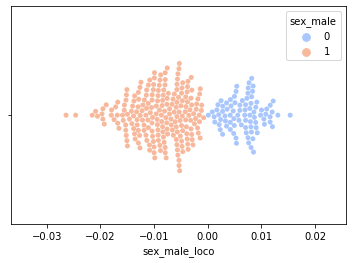

In [8]:
%matplotlib inline
loco_data.reindex(np.random.permutation(loco_data.index))
num_plot_points = 300

#sns.swarmplot(x="foreign_yes_loco", hue="foreign_yes", data=loco_data[:num_plot_points], y=[""]*num_plot_points, palette='coolwarm')
sns.swarmplot(x="sex_male_loco", hue="sex_male", data=loco_data[:num_plot_points], y=[""]*num_plot_points, palette='coolwarm')

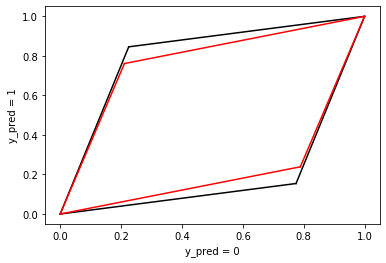

In [9]:
%matplotlib inline

def find_rate_class(prediction: str, pred_high, label: str, label_val, class_name: str, class_val, data):
    filtered_data = data.query(class_name + " == " + str(class_val)).query(label + " == " + str(label_val))
    total_data = filtered_data.shape[0]
    total_ones = filtered_data.query(prediction + " == " + str(pred_high)).shape[0]
    return total_ones/total_data

aa_tpr = find_rate_class("y_pred", 1, "accepted", 1, "sex_male", 1, learning_data)
aa_fpr = find_rate_class("y_pred", 1, "accepted", 0, "sex_male", 1, learning_data)
# race_Caucasian
o_tpr = find_rate_class("y_pred", 1, "accepted", 1, "sex_male", 0, learning_data)
o_fpr = find_rate_class("y_pred", 1, "accepted", 0, "sex_male", 0, learning_data)

# plot convex hull (fpr = x axis tpr = y axis)
gamma_aa_1 = (find_rate_class("y_pred", 1, "accepted", 0, "sex_male", 1, learning_data), 
              find_rate_class("y_pred", 1, "accepted", 1, "sex_male", 1, learning_data))
gamma_aa_0 = (find_rate_class("y_pred", 0, "accepted", 0, "sex_male", 1, learning_data), 
              find_rate_class("y_pred", 0, "accepted", 1, "sex_male", 1, learning_data))

gamma_o_1 = (find_rate_class("y_pred", 1, "accepted", 0, "sex_male", 0, learning_data), 
             find_rate_class("y_pred", 1, "accepted", 1, "sex_male", 0, learning_data))
gamma_o_0 = (find_rate_class("y_pred", 0, "accepted", 0, "sex_male", 0, learning_data), 
             find_rate_class("y_pred", 0, "accepted", 1, "sex_male", 0, learning_data))


points = np.array([(0,0), gamma_aa_0, gamma_aa_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

points = np.array([(0,0), gamma_o_0, gamma_o_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-')
plt.ylabel('y_pred = 1')
plt.xlabel('y_pred = 0')

plt.show();

### Equalized Odds

In [10]:
from collections import namedtuple

class Model(namedtuple('Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label

    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        self_fair_pred = self.pred.copy()
        self_pp_indices, = np.nonzero(self.pred.round())
        self_pn_indices, = np.nonzero(1 - self.pred.round())
        np.random.shuffle(self_pp_indices)
        np.random.shuffle(self_pn_indices)

        n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
        self_fair_pred[n2p_indices] = 1 - self_fair_pred[n2p_indices]
        p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
        self_fair_pred[p2n_indices] = 1 - self_fair_pred[p2n_indices]

        othr_fair_pred = othr.pred.copy()
        othr_pp_indices, = np.nonzero(othr.pred.round())
        othr_pn_indices, = np.nonzero(1 - othr.pred.round())
        np.random.shuffle(othr_pp_indices)
        np.random.shuffle(othr_pn_indices)

        n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
        othr_fair_pred[n2p_indices] = 1 - othr_fair_pred[n2p_indices]
        p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
        othr_fair_pred[p2n_indices] = 1 - othr_fair_pred[p2n_indices]

        fair_self = Model(self_fair_pred, self.label)
        fair_othr = Model(othr_fair_pred, othr.label)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr

    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [11]:
test_and_val_data = learning_data[['pred', 'accepted', 'sex_male']]
    
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]

group_0_val_data = val_data[val_data['sex_male'] == 1]
group_1_val_data = val_data[val_data['sex_male'] == 0]
group_0_test_data = test_data[test_data['sex_male'] == 1]
group_1_test_data = test_data[test_data['sex_male'] == 0]


In [12]:
group_0_val_model  = Model(group_0_val_data['pred'].as_matrix(), group_0_val_data['accepted'].as_matrix())
group_1_val_model  = Model(group_1_val_data['pred'].as_matrix(), group_1_val_data['accepted'].as_matrix())
group_0_test_model = Model(group_0_test_data['pred'].as_matrix(), group_0_test_data['accepted'].as_matrix())
group_1_test_model = Model(group_1_test_data['pred'].as_matrix(), group_1_test_data['accepted'].as_matrix())

# Find mixing rates for equalized odds models
_, _, mix_rates = Model.eq_odds(group_0_val_model, group_1_val_model)

# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                       group_1_test_model,
                                                                       mix_rates)

# Print results on test model
print('Original group male model:\n%s\n' % repr(group_0_test_model))
print('Original group female model:\n%s\n' % repr(group_1_test_model))
print('Equalized odds group male model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group female model:\n%s\n' % repr(eq_odds_group_1_test_model))

Original group male model:
Accuracy:	0.833
F.P. cost:	0.525
F.N. cost:	0.257
Base rate:	0.717
Avg. score:	0.681

Original group female model:
Accuracy:	0.774
F.P. cost:	0.506
F.N. cost:	0.280
Base rate:	0.628
Avg. score:	0.640

Equalized odds group male model:
Accuracy:	0.792
F.P. cost:	0.525
F.N. cost:	0.283
Base rate:	0.717
Avg. score:	0.662

Equalized odds group female model:
Accuracy:	0.750
F.P. cost:	0.520
F.N. cost:	0.277
Base rate:	0.628
Avg. score:	0.647



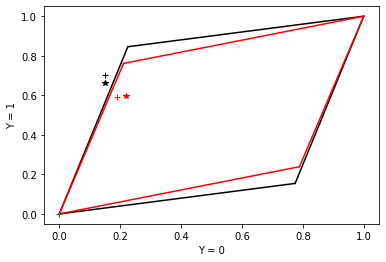

In [13]:
points = np.array([(0,0), gamma_aa_0, gamma_aa_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

points = np.array([(0,0), gamma_o_0, gamma_o_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-')
    
plt.plot(group_0_val_model.fpr(), group_0_val_model.tpr(), 'k+')
plt.plot(group_1_val_model.fpr(), group_1_val_model.tpr(), 'r+')
plt.plot(eq_odds_group_0_test_model.fpr(), eq_odds_group_0_test_model.tpr(), 'k*')
plt.plot(eq_odds_group_1_test_model.fpr(), eq_odds_group_1_test_model.tpr(), 'r*')

plt.plot(0, 0, 'g+')

plt.ylabel('Y = 1')
plt.xlabel('Y = 0')

plt.show();